In [25]:
!pip install wordcloud

In [29]:
# Data Structures
import numpy  as np
import pandas as pd
import json

# K-Means
from sklearn import cluster

# Visualization and Analysis
import matplotlib.pyplot  as plt
import matplotlib.cm      as cm
import seaborn            as sns
from sklearn.metrics                  import silhouette_samples, silhouette_score
from wordcloud                        import WordCloud

In [9]:
def run_KMeans(max_k, data):
    max_k += 1
    kmeans_results = dict()
    for k in range(2 , max_k):
        kmeans = cluster.KMeans(n_clusters = k
                               , init = 'k-means++'
                               , n_init = 10
                               , tol = 0.0001
                               , n_jobs = -1
                               , random_state = 1
                               , algorithm = 'full')

        kmeans_results.update( {k : kmeans.fit(data)} )
        
    return kmeans_results

In [10]:
def printAvg(avg_dict):
    for avg in sorted(avg_dict.keys(), reverse=True):
        print("Avg: {}\tK:{}".format(avg.round(4), avg_dict[avg]))
        
def plotSilhouette(df, n_clusters, kmeans_labels, silhouette_avg):
    fig, ax1 = plt.subplots(1)
    fig.set_size_inches(8, 6)
    ax1.set_xlim([-0.2, 1])
    ax1.set_ylim([0, len(df) + (n_clusters + 1) * 10])
    
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--") # The vertical line for average silhouette score of all the values
    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.title(("Silhouette analysis for K = %d" % n_clusters), fontsize=10, fontweight='bold')
    
    y_lower = 10
    sample_silhouette_values = silhouette_samples(df, kmeans_labels) # Compute the silhouette scores for each sample
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[kmeans_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i)) # Label the silhouette plots with their cluster numbers at the middle
        y_lower = y_upper + 10  # Compute the new y_lower for next plot. 10 for the 0 samples
    plt.show()
    
        
def silhouette(kmeans_dict, df, plot=False):
    df = df.to_numpy()
    avg_dict = dict()
    for n_clusters, kmeans in kmeans_dict.items():      
        kmeans_labels = kmeans.predict(df)
        silhouette_avg = silhouette_score(df, kmeans_labels) # Average Score for all Samples
        avg_dict.update( {silhouette_avg : n_clusters} )
    
        if(plot): plotSilhouette(df, n_clusters, kmeans_labels, silhouette_avg)

In [ ]:
# read file
df = pd.read_csv("mostFreq1000wordDataT.csv")

# convert first column into row indices
df.set_index('Words', inplace=True)

# display
display(df)

k = 10
kmeans_results = run_KMeans(k, df)

# Plotting Silhouette Analysis
silhouette(kmeans_results, df, plot=True)

In [103]:
# Change this function so it only uses data frame
def get_top_features_cluster(tf_idf_array, idx, prediction, n_feats):
    labels = np.unique(prediction)
    dfs = []
    for label in labels:
        id_temp = np.where(prediction==label) # indices for each cluster 
        x_means = np.mean(tf_idf_array[id_temp], axis = 0) # returns average score across cluster
        sorted_means = np.argsort(x_means)[::-1][:n_feats] # indices with top 20 scores        
        best_features = [(idx[i], x_means[i]) for i in sorted_means]
        df = pd.DataFrame(best_features, columns = ['features', 'score'])
        dfs.append(df)
    return dfs

def plotWords(dfs, n_feats):
    plt.figure(figsize=(10, 6))
    for i in range(0, len(dfs)):
        plt.title(("Most Common Words in Cluster {}".format(i)), fontsize=10, fontweight='bold')
        sns.barplot(x = 'score' , y = 'features', orient = 'h' , data = dfs[i][:n_feats])
        plt.show()

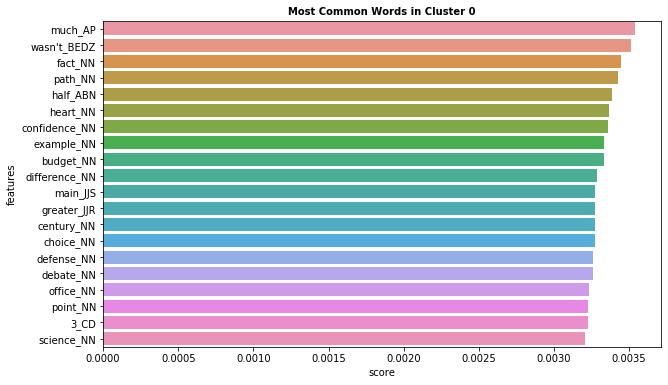

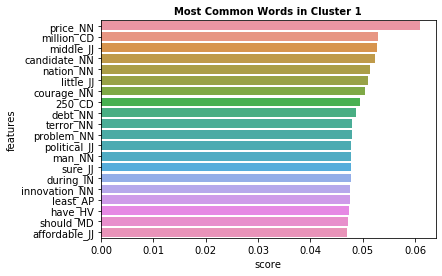

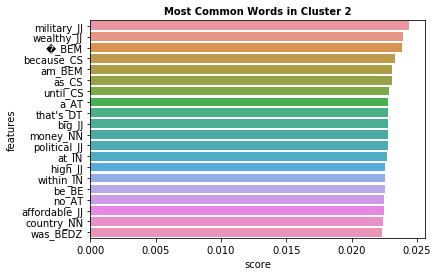

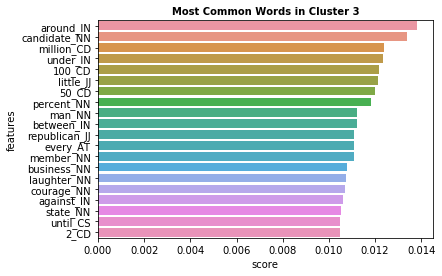

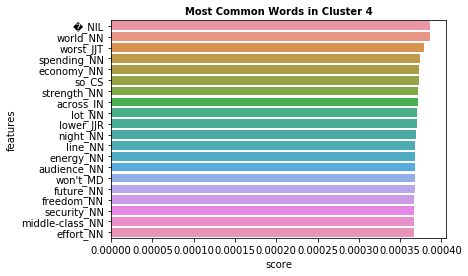

In [133]:
best_result = 5
kmeans = kmeans_results.get(best_result)

df_array = df.to_numpy()
dfi = df.index.to_numpy()

prediction = kmeans.predict(df)
n_feats = 20
dfs = get_top_features_cluster(df_array, dfi, prediction, n_feats)
plotWords(dfs, 20)

In [126]:
# Transforms a centroids dataframe into a dictionary to be used on a WordCloud.
def centroidsDict(centroids, index):
    a = centroids.T[index].sort_values(ascending = False).reset_index().values
    centroid_dict = dict()

    for i in range(0, len(a)):
        centroid_dict.update( {a[i,0] : a[i,1]} )

    return centroid_dict

def generateWordClouds(centroids):
    wordcloud = WordCloud(max_font_size=100, background_color = 'white')
    for i in range(0, len(centroids)):
        centroid_dict = centroidsDict(centroids, i)        
        wordcloud.generate_from_frequencies(centroid_dict)

        plt.figure()
        plt.title('Cluster {}'.format(i))
        plt.imshow(wordcloud)
        plt.axis("off")
        plt.show()

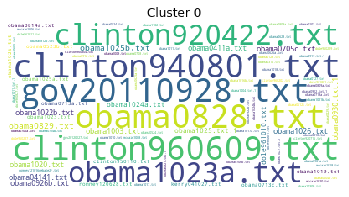

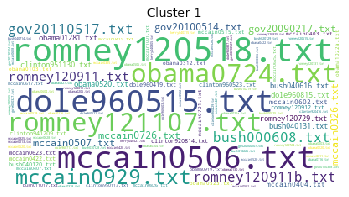

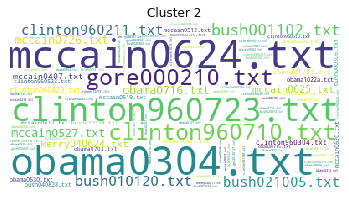

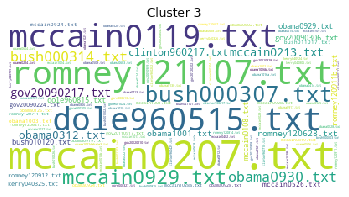

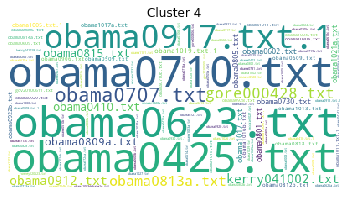

In [127]:
centroids = pd.DataFrame(kmeans.cluster_centers_)
centroids.columns = df.columns
generateWordClouds(centroids)